In [158]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [159]:
pltmap = plt.get_cmap("tab10")

In [160]:
from scipy.signal import find_peaks
from scipy.optimize import curve_fit

In [161]:
# math functions for automated peak fitting
def gaussian(x, a, mu, width, b, c):
    return(a*np.exp(-(x-mu)**2 / (2*width**2)) + b*x + c)
def gaussian_nobg(x, a, mu, width):
    return(a*np.exp(-(x-mu)**2 / (2*width**2)))
def gaussian_cbg(x, a, mu, width, c):
    return(a*np.exp(-(x-mu)**2 / (2*width**2)) + c)

## Data format

Each bioD spectrum is 2048 channels (keV) with two columns in front for Rack, Vial index. There is a "blank" at the end of every rack.

## Gamma counter
Hidex automatic gamma counter

NaI detector, lead shields

## Efficiency
I googled around for some Hidex technical documents and found really inconsistent and sometimes nonsensical efficiency calibrations, so we're gonna use an Ac-225 known source activity

In [289]:
# manually set energy windows for the peaks, adjust as desired
ROIFr_cali = np.array([175, 250])
ROIBi_cali = np.array([385, 490])

# hidex calibration data with ac225

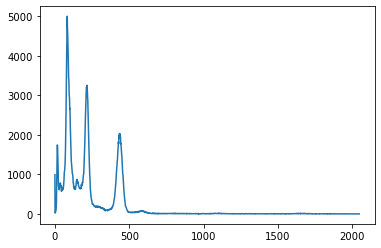

In [395]:
# known source activities
%matplotlib inline
uCi = np.repeat([1, 0.5, 0.2, 0.1, 0.04, 0.008], 3) 
# uCi = np.repeat( np.array( [ 2, 1, 0.5, 0.25, 0.125, 0.0625, 0.03125, 0.015625 ] ) , 3 ) 
spectra = pd.read_csv('/Users/eframe/Downloads/HidexAMG-225Ac-standard.csv', header=None).T
# spectra = pd.read_csv('/Users/eframe/dmi/data/calibration.csv', header=None).T

# vial 10 in each rack is not a measurement
kev = np.arange(2048)
plt.plot(kev, spectra[0]) # example spectrum
plt.show()
plt.close()

# show an example of fits with a sample spectrum

In [396]:
energy = kev.copy()
emask218 = ( energy > 175 ) & ( energy < 250 )
bmask218 = ( ( energy < 175 ) & ( energy > 175 - 37.5 ) ) | ( ( energy > 250 ) & ( energy < 250 - 37.5 ) )

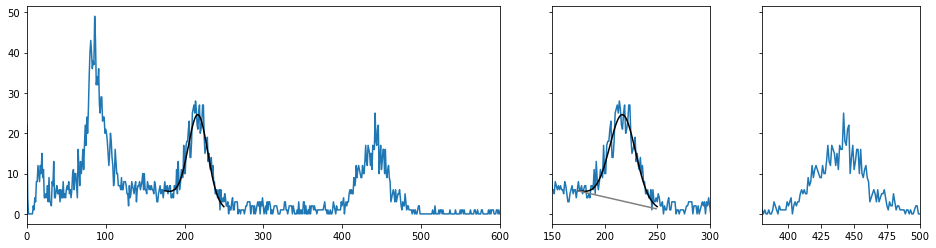

In [397]:
sample_spectrum = spectra[17]

f, ax = plt.subplots(1,3,figsize=(16,4), sharey=True,
                    gridspec_kw={'width_ratios': [3, 1, 1]})

ax[0].plot(kev, sample_spectrum)
ax[1].plot(kev, sample_spectrum)
ax[2].plot(kev, sample_spectrum)

ax[0].set_xlim([0,600])
ax[1].set_xlim([150, 300])
ax[2].set_xlim([380, 500])

# fit Fr peak: gaussian with linear bg
xdata = kev[ROIFr_cali[0]:ROIFr_cali[1]]
xspace = np.linspace(ROIFr_cali[0], ROIFr_cali[1], 500)
p0 = [200, 218, 30, -0.5, 10]

ydata = sample_spectrum[ROIFr_cali[0]:ROIFr_cali[1]]
dy = np.maximum(np.sqrt(ydata), np.ones_like(ydata))
popt, pcov = curve_fit(gaussian, xdata, ydata, sigma=dy, p0=p0, maxfev=5000)
perr = np.sqrt(np.diag(pcov))

bg = popt[3] * xdata + popt[4]
dbg = np.sqrt((perr[3])**2 + (perr[4])**2)

net_data = ydata-bg
net_data = np.maximum(net_data, np.zeros_like(net_data))
net_cts = np.sum(net_data)
darray = np.sqrt(dy**2 + dbg**2)
dnet = np.sqrt(np.sum(darray**2))
gross_cts = np.sum(ydata)

ax[0].plot(xspace, gaussian(xspace, *popt), color='black', label='Fit')
ax[1].plot(xspace, gaussian(xspace, *popt), color='black', label='Fit')
ax[1].plot(xdata, bg, color='gray')

# # fit Bi peak: gaussian with linear bg
# xdata = kev[ROIBi_cali[0]:ROIBi_cali[1]]
# xspace = np.linspace(ROIBi_cali[0], ROIBi_cali[1], 500)
# p0 = [1000, 200, 440, -0.5, 10]

# ydata = sample_spectrum[ROIBi_cali[0]:ROIBi_cali[1]]
# dy = np.maximum(np.sqrt(ydata), np.ones_like(ydata))
# popt, pcov = curve_fit(gaussian, xdata, ydata, sigma=dy, p0=p0, maxfev=5000)

# bg = popt[3] * xdata + popt[4]
# dbg = np.sqrt((perr[3])**2 + (perr[4])**2)

# net_data = ydata-bg
# net_data = np.maximum(net_data, np.zeros_like(net_data))
# net_cts = np.sum(net_data)
# darray = np.sqrt(dy**2 + dbg**2)
# dnet = np.sqrt(np.sum(darray**2))
# gross_cts = np.sum(ydata)

# ax[0].plot(xspace, gaussian(xspace, *popt), color='black', label='Fit')
# ax[2].plot(xspace, gaussian(xspace, *popt), color='black', label='Fit')
# ax[2].plot(xdata, bg, color='gray')
# plt.legend()
# plt.show()

# apply to all calibration spectra

In [398]:
data_matrix = np.zeros( (uCi.shape[0], 6) )
# fr_nets, dfr_nets, fr_gross, bi_nets, dbi_nets, bi_gross
data_matrix.shape

(18, 6)

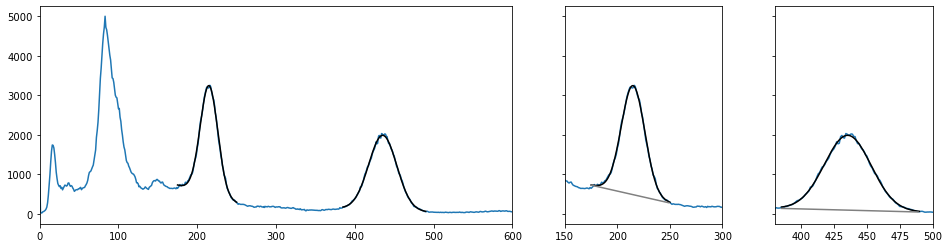

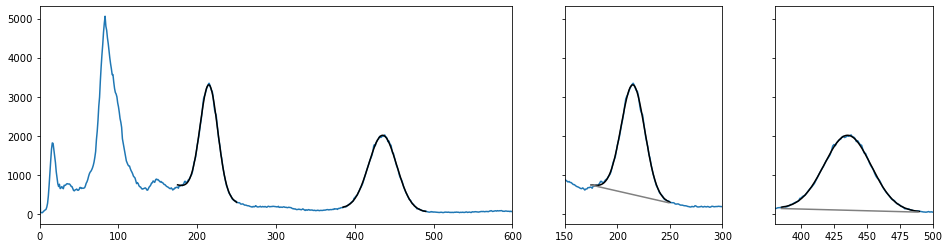

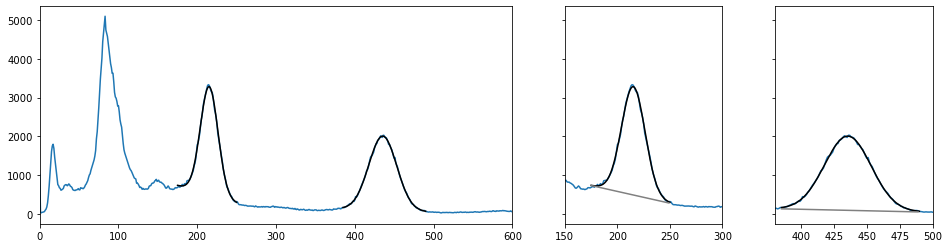

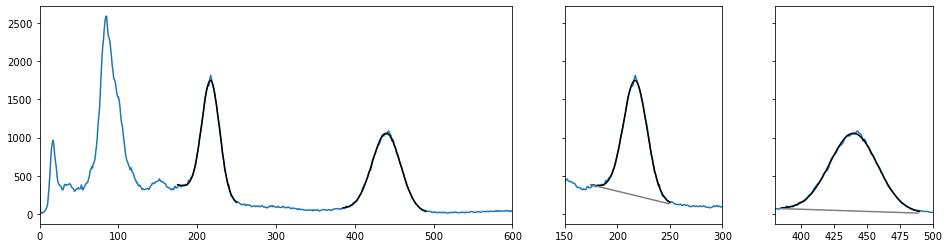

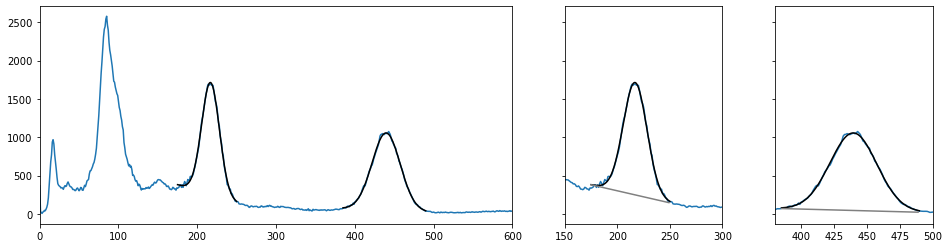

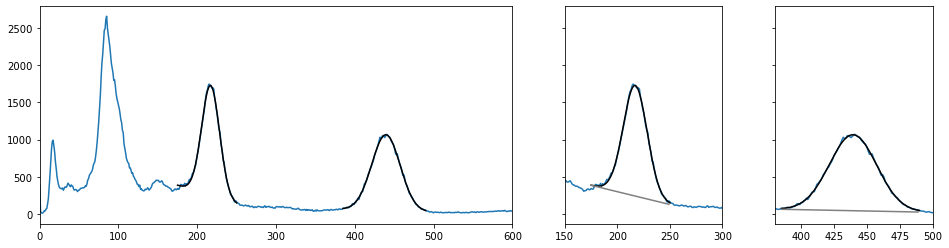

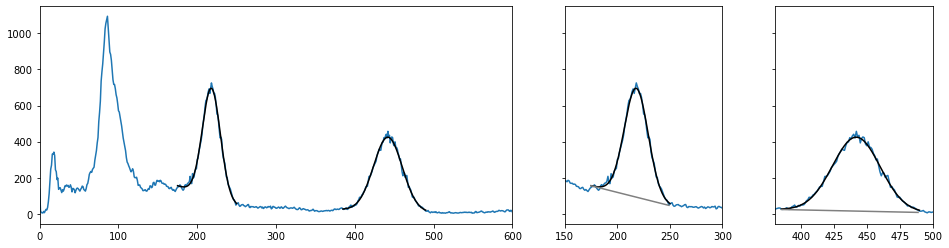

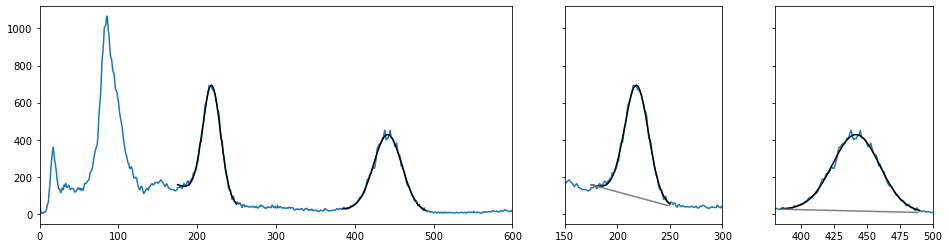

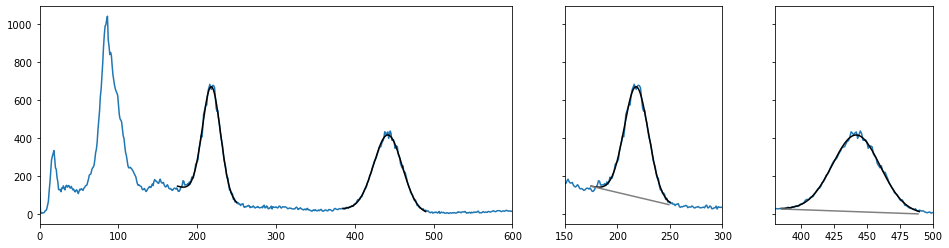

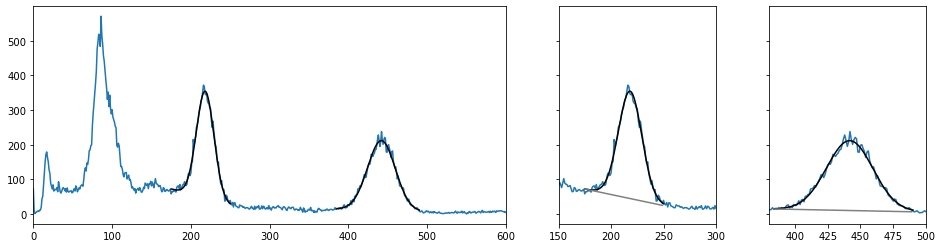

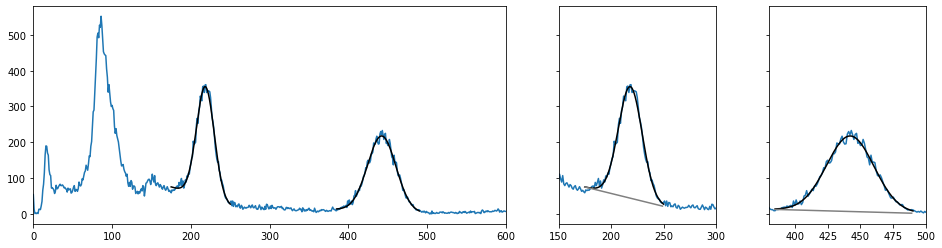

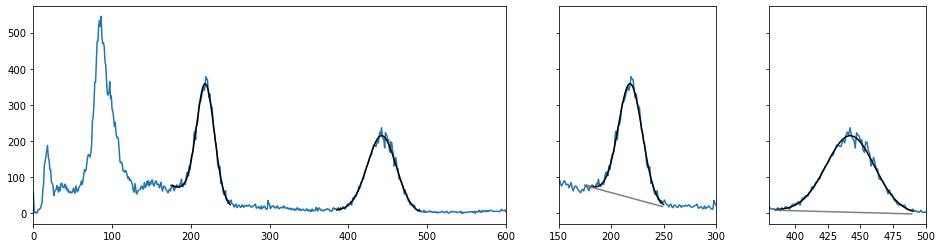

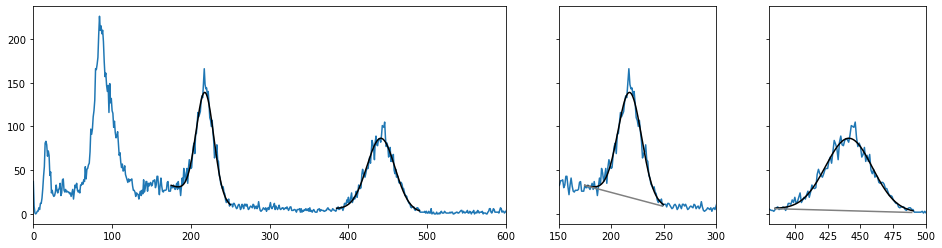

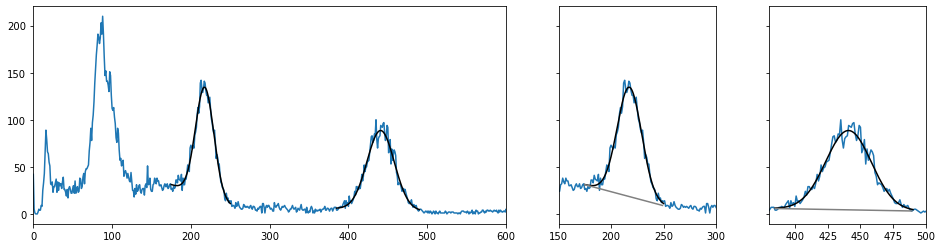

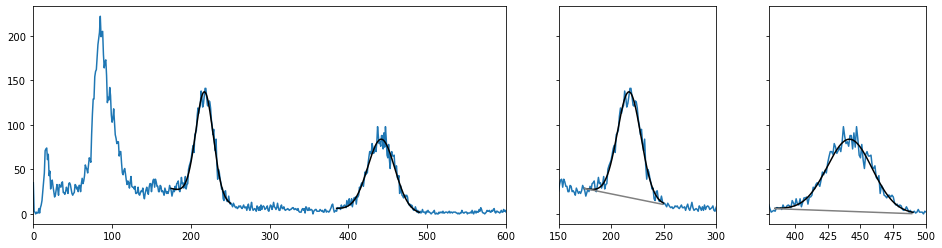

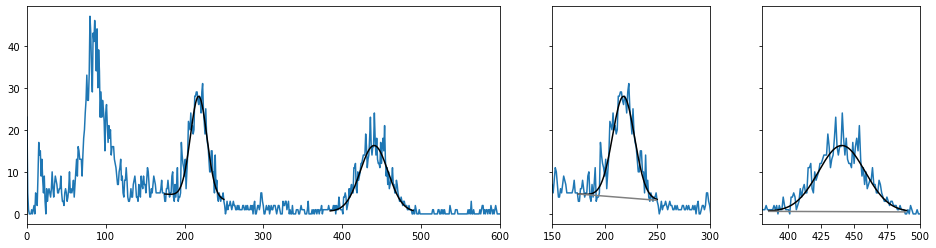

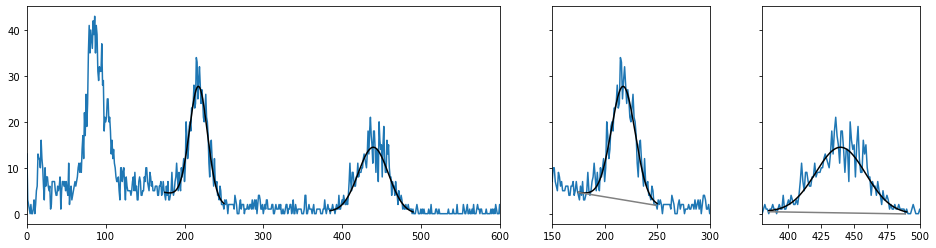

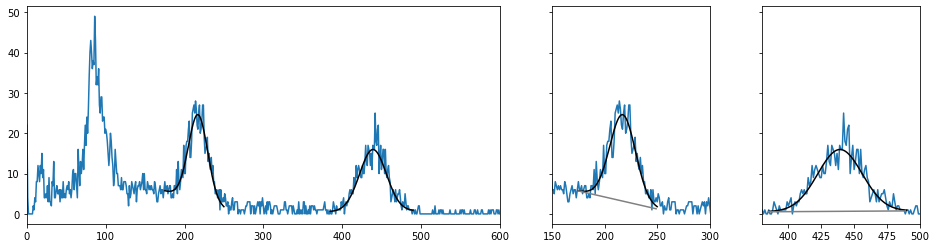

In [399]:
for i in range( uCi.shape[0] ):
    spectrum = spectra[i]
    f, ax = plt.subplots(1,3,figsize=(16,4), sharey=True,
                        gridspec_kw={'width_ratios': [3, 1, 1]})

    ax[0].plot(kev, spectrum)
    ax[1].plot(kev, spectrum)
    ax[2].plot(kev, spectrum)

    ax[0].set_xlim([0,600])
    ax[1].set_xlim([150, 300])
    ax[2].set_xlim([380, 500])

    # fit Fr peak: gaussian with linear bg
    xdata = kev[ROIFr_cali[0]:ROIFr_cali[1]]
    xspace = np.linspace(ROIFr_cali[0], ROIFr_cali[1], 500)
    p0 = [200, 218, 30, -0.5, 10]

    ydata = spectrum[ROIFr_cali[0]:ROIFr_cali[1]]
    dy = np.maximum(np.sqrt(ydata), np.ones_like(ydata))
    popt, pcov = curve_fit(gaussian, xdata, ydata, sigma=dy, p0=p0, maxfev=5000)
    perr = np.sqrt(np.diag(pcov))

    bg = popt[3] * xdata + popt[4]
    dbg = np.sqrt((perr[3])**2 + (perr[4])**2)

    net_data = ydata-bg
    net_data = np.maximum(net_data, np.zeros_like(net_data))
    net_cts = np.sum(net_data)
    darray = np.sqrt(dy**2 + dbg**2)
    dnet = np.sqrt(np.sum(darray**2))
    gross_cts = np.sum(ydata)

    ax[0].plot(xspace, gaussian(xspace, *popt), color='black', label='Fit')
    ax[1].plot(xspace, gaussian(xspace, *popt), color='black', label='Fit')
    ax[1].plot(xdata, bg, color='gray')
    
    data_matrix[i, 0] = net_cts
    data_matrix[i, 1] = dnet
    data_matrix[i, 2] = gross_cts

    # fit Bi peak: gaussian with linear bg
    xdata = kev[ROIBi_cali[0]:ROIBi_cali[1]]
    xspace = np.linspace(ROIBi_cali[0], ROIBi_cali[1], 500)
    p0 = [1000, 200, 440, -0.5, 10]

    ydata = spectrum[ROIBi_cali[0]:ROIBi_cali[1]]
    dy = np.maximum(np.sqrt(ydata), np.ones_like(ydata))
    popt, pcov = curve_fit(gaussian, xdata, ydata, sigma=dy, p0=p0, maxfev=5000)

    bg = popt[3] * xdata + popt[4]
    dbg = np.sqrt((perr[3])**2 + (perr[4])**2)

    net_data = ydata-bg
    net_data = np.maximum(net_data, np.zeros_like(net_data))
    net_cts = np.sum(net_data)
    darray = np.sqrt(dy**2 + dbg**2)
    dnet = np.sqrt(np.sum(darray**2))
    gross_cts = np.sum(ydata)
    
    data_matrix[i, 3] = net_cts
    data_matrix[i, 4] = dnet
    data_matrix[i, 5] = gross_cts

    ax[0].plot(xspace, gaussian(xspace, *popt), color='black', label='Fit')
    ax[2].plot(xspace, gaussian(xspace, *popt), color='black', label='Fit')
    ax[2].plot(xdata, bg, color='gray')

    plt.show()

In [400]:
fr_counts = data_matrix[:,0]
bi_counts = data_matrix[:,3]

In [401]:
fr_cpm = np.insert( np.mean(fr_counts.reshape(-1, 3), axis=1), 6, 0 ) 
bi_cpm = np.insert( np.mean(bi_counts.reshape(-1, 3), axis=1), 6, 0 ) 
activity = np.insert( np.mean(uCi.reshape(-1, 3), axis=1), 6, 0 )

In [402]:
p_fr = np.poly1d( np.polyfit( fr_cpm, activity, 1 ) ) 
p_bi = np.poly1d( np.polyfit( bi_cpm, activity, 1 ) )

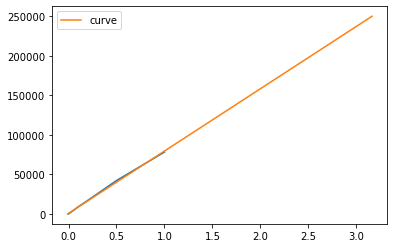

In [403]:
%matplotlib inline
plt.plot(activity, fr_cpm )
plt.plot(p_fr(np.arange(0,250000) ), np.arange(0,250000), label='curve')
plt.legend()
plt.show()

In [404]:
fr_counts

array([77155.27723112, 78963.3452268 , 78612.0373697 , 42452.14231794,
       41627.47041982, 42538.0861605 , 17265.66760017, 17122.35529674,
       16876.20646812,  8756.43043586,  8900.47518896,  8974.27191442,
        3443.06572814,  3436.67007894,  3367.97764033,   696.7380531 ,
         749.6200102 ,   699.11200712])

# look at efficiency

In [407]:
cts_theory = uCi * 37000 # uCi --> Bq --> 30s of measurement
fr_theory = 0.116 * cts_theory
bi_theory = 0.261 * cts_theory

fr_eff = ( data_matrix[:,0] / 30 ) / cts_theory
bi_eff = ( data_matrix[:,3] / 30 ) / cts_theory

det_eff = np.array([np.mean(fr_eff), np.mean(bi_eff)])
det_eff

array([0.0768256 , 0.08203198])

In [250]:
plt.plot(fr_eff, label='Fr221')
plt.plot(bi_eff, label='Bi213')
plt.xlabel('energy (keV)')
plt.ylabel('efficiency')
plt.legend()
plt.show()

In [279]:
771552 / 30 / 0.66629 

38599.40866589623

In [280]:
38599 / 37000

1.0432162162162162